# PREOPS-1153: Test decorrelation afterburner fix

### Run tract 4431 in DC2 with the decorrelation afterburner fix. Compare the results with the existing 4431 processing in w_2021_40.

## NOTE: Be sure to have at 12 GB of memory available to run this 

In [1]:
import os
import sys
import gc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import importlib
import pandas as pd

from astropy.coordinates import SkyCoord
import astropy.units as u
from types import SimpleNamespace
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize, LinearStretch)
from operator import itemgetter
from itertools import groupby


import lsst.geom
import lsst.afw.display as afwDisplay
import lsst.afw.display as afw_display
afwDisplay.setDefaultBackend('matplotlib')
import lsst.daf.butler as dafButler
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
from lsst.pipe.base import Struct
import astropy.coordinates as coord
import pyarrow.parquet as pq
import lsst.afw.cameraGeom as cameraGeom
#from lsst.obs.hsc import HscMapper as mapper

Overriding default configuration file with /opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-4.0.1/Linux64/dustmaps_cachedata/g41a3ec361e+ac198e9f13/config/.dustmapsrc


In [2]:
truthparquet = '/project/shared/DC2/truth_parquet/truth_tract4431.parq'

In [3]:
#Various tables for truth studies
if os.path.exists(truthparquet):
    print(truthparquet + ' exists.')
    try:
        truth = pq.read_pandas(truthparquet).to_pandas()
    except:
        print('This is not working.')
else:
    print('Cannot find' + truthparquet)
print(len(truth))


/project/shared/DC2/truth_parquet/truth_tract4431.parq exists.
4817461


In [4]:
truthsc = coord.SkyCoord(truth.ra,truth.dec,unit='deg')

In [5]:
repo = '/repo/dc2'
collection40 = 'u/kherner/2.2i/runs/tract4431-w40'
collection = 'u/kherner/2.2i/runs/PREOPS-1153-v23_0_2_rc2'
butler40 = dafButler.Butler(repo, collections=collection40)
butler = dafButler.Butler(repo, collections=collection)

In [6]:
wherestr="instrument='LSSTCam-imSim' and tract=4431 and skymap='DC2'"


dataIds40 = set(butler40.registry.queryDataIds(['band', 'instrument', 'detector',
                                         'physical_filter', 'visit_system', 'visit'],
                                        datasets="goodSeeingDiff_diaSrcTable",
                                        collections=collection40,
                                        where=wherestr))

dataIds = set(butler.registry.queryDataIds(['band', 'instrument', 'detector',
                                         'physical_filter', 'visit_system', 'visit'],
                                        datasets="goodSeeingDiff_diaSrcTable",
                                        collections=collection,
                                        where=wherestr))
tables40 = []
for dataId in dataIds40:
    tables40.append(butler40.get('goodSeeingDiff_diaSrcTable', dataId=dataId))
tablesrc2 = []
for dataId in dataIds:
    tablesrc2.append(butler.get('goodSeeingDiff_diaSrcTable', dataId=dataId))

In [7]:
df40 = pd.concat(tables40)
df   = pd.concat(tablesrc2)

In [8]:
del tables40
del tablesrc2

In [9]:
config = TransformDiaSourceCatalogConfig()
unpacker = UnpackApdbFlags(config.flagMap, 'DiaSource')

In [10]:
instrumentDataId = butler40.registry.expandDataId(instrument='LSSTCam-imSim')
packer = butler40.registry.dimensions.makePacker("visit_detector", instrumentDataId)
df40['visit'] = df40.ccdVisitId.apply(lambda x: packer.unpack(x)['visit'])
df40['detector'] = df40.ccdVisitId.apply(lambda x: packer.unpack(x)['detector'])
instrumentDataId = butler.registry.expandDataId(instrument='LSSTCam-imSim')
packer = butler.registry.dimensions.makePacker("visit_detector", instrumentDataId)
df['visit'] = df.ccdVisitId.apply(lambda x: packer.unpack(x)['visit'])
df['detector'] = df.ccdVisitId.apply(lambda x: packer.unpack(x)['detector'])


In [11]:
# create some derived columns

pixToArcseconds = 0.2
PIXEL_SCALE = 0.2
SIGMA2FWHM = 2*np.sqrt(2*np.log(2))
traceRadius = np.sqrt(0.5) * np.sqrt(df.ixxPSF + df.iyyPSF)
df['seeing'] = SIGMA2FWHM * traceRadius
myvisit = 993521
mydet = 76
bbox = butler40.get('goodSeeingDiff_differenceExp.bbox', visit = myvisit , detector=mydet)
wcs = butler40.get('goodSeeingDiff_differenceExp.wcs', visit = myvisit , detector=mydet)
APPROX_CCD_AREA = bbox.getArea()*wcs.getPixelScale().asDegrees()**2

Pick a random detector/visit combo and make a few diagnostic plots

In [12]:
myvisit=193824
#myvisit=479254
mydetector=3
patch=42


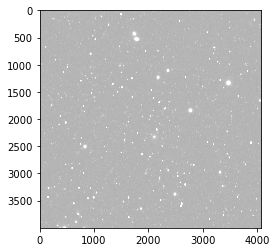

In [13]:
myId = { "skymap": "DC2", "tract": 4431, "instrument":"LSSTCam-imSim"}
mydet = mydetector
calexp = butler.get('calexp',visit = myvisit, detector = mydet, dataId=myId)
calexpNorm = ImageNormalize(calexp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
plt.imshow(calexp.image.array, cmap='gray', norm=calexpNorm)

     inf
26803.138672
     nan


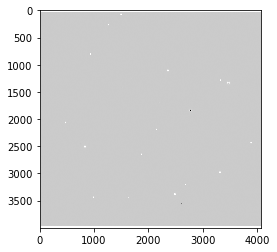

In [14]:
diffim = butler.get('goodSeeingDiff_differenceExp',visit = myvisit, detector = mydet, dataId=myId)
diffimNorm = ImageNormalize(diffim.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
plt.imshow(diffim.image.array, cmap='gray',norm=diffimNorm)
print(f'{np.mean(diffim.variance.array):8f}')
print(f'{np.median(diffim.variance.array):8f}')
print(f'{np.median(diffim.image.array):8f}')
templ = butler.get('goodSeeingDiff_templateExp',visit = myvisit, detector = mydet, dataId=myId)
templNorm = ImageNormalize(templ.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
#If you want to plot the template instead
#plt.imshow(templ.image.array, cmap='gray',norm=templNorm)
# mean, median of variance plane and median of diffim image plane

732.949158
725.401062
     nan


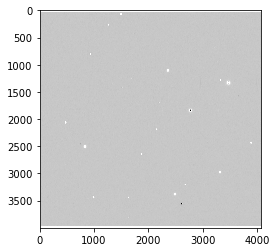

In [15]:
diffim40 = butler40.get('goodSeeingDiff_differenceExp',visit = myvisit, detector = mydet, dataId=myId)
diffimNorm40 = ImageNormalize(diffim40.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
plt.imshow(diffim40.image.array, cmap='gray',norm=diffimNorm40)
print(f'{np.mean(diffim40.variance.array):8f}')
print(f'{np.median(diffim40.variance.array):8f}')
print(f'{np.median(diffim40.image.array):8f}')
templ40 = butler40.get('goodSeeingDiff_templateExp',visit = myvisit, detector = mydet, dataId=myId)
templNorm40 = ImageNormalize(templ40.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
#If you want to plot the template instead
#plt.imshow(templ40.image.array, cmap='gray',norm=templNorm40)


In [16]:
# get Focal Plane Coordinates (is there a faster way to do this?)
camera = butler.get('camera', instrument='LSSTCam-imSim')

def ccd2focalPlane(x, y, ccd):
    cc = int(ccd)
    det = camera[cc]
    point = det.transform(lsst.geom.Point2D(x, y), cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
    return point[0], point[1]

# Useful code but we don't use it now, so comment it out.
#vecCcd2FP =  np.vectorize(ccd2focalPlane)
#focal_plane = vecCcd2FP(df['x'].values.astype(float), df['y'].values.astype(float), df['detector'].values.astype(int))
#df['xFP'] = focal_plane[0]
#df['yFP'] = focal_plane[1]
#focal_plane = vecCcd2FP(df40['x'].values.astype(float), df40['y'].values.astype(float), df40['detector'].values.astype(int))
#df40['xFP'] = focal_plane[0]
#df40['yFP'] = focal_plane[1]

In [17]:
pixelFlagNames = [
       'base_PixelFlags_flag_offimage',
       'base_PixelFlags_flag_edge',
       'base_PixelFlags_flag_interpolated',
       'base_PixelFlags_flag_saturated',
       'base_PixelFlags_flag_cr',
       'base_PixelFlags_flag_bad',
       'base_PixelFlags_flag_suspect',
       'base_PixelFlags_flag_interpolatedCenter',
       'base_PixelFlags_flag_saturatedCenter',
       'base_PixelFlags_flag_crCenter',
       'base_PixelFlags_flag_suspectCenter']

centroidFlagNames = [
       'slot_Centroid_flag',
       'slot_Centroid_pos_flag',
       'slot_Centroid_neg_flag',]
    
fluxFlagNames = [
       'slot_ApFlux_flag',
       'slot_ApFlux_flag_apertureTruncated',
       'slot_PsfFlux_flag',
       'slot_PsfFlux_flag_noGoodPixels',
       'slot_PsfFlux_flag_edge',
       'ip_diffim_forced_PsfFlux_flag',
       'ip_diffim_forced_PsfFlux_flag_noGoodPixels',
       'ip_diffim_forced_PsfFlux_flag_edge']

shapeFlagNames = [
       'slot_Shape_flag',
       'slot_Shape_flag_unweightedBad',
       'slot_Shape_flag_unweighted',
       'slot_Shape_flag_shift',
       'slot_Shape_flag_maxIter',
       'slot_Shape_flag_psf']

Diagnostic plots to be sure we aren't missing sources in particular regions of the sty.

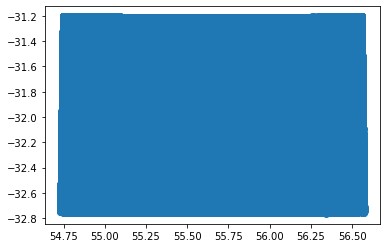

In [18]:
plt.scatter(df.ra,df.decl)

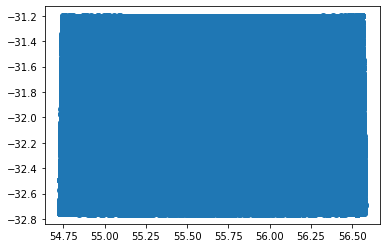

In [19]:
plt.scatter(df40.ra,df40.decl)

In [20]:
diaSourcesc = coord.SkyCoord(df.ra,df.decl,unit='deg')
diaSourcesc40 = coord.SkyCoord(df40.ra,df40.decl,unit='deg')

Source counts in each case per band

In [21]:
dfb = {}
dfb40 = {}
for myband in [ 'g', 'r', 'i', 'z', 'u', 'y']:
    dfb[myband] = df.loc[df['filterName']==myband]
    print('Number of %s-band sources rc2: %d' % (myband, len(dfb[myband])))
    dfb40[myband] = df40.loc[df40['filterName']==myband]
    print('Number of %s-band sources w40: %d' % (myband, len(dfb40[myband])))

Number of g-band sources rc2: 189245
Number of g-band sources w40: 180352
Number of r-band sources rc2: 967666
Number of r-band sources w40: 338744
Number of i-band sources rc2: 963399
Number of i-band sources w40: 292294
Number of z-band sources rc2: 424141
Number of z-band sources w40: 115830
Number of u-band sources rc2: 118074
Number of u-band sources w40: 44177
Number of y-band sources rc2: 166475
Number of y-band sources w40: 70598


In [22]:
# Clean these up to keep memory consumption down if needed, since we don't use them later.
dfb.clear()
dfb40.clear()

### What happened?

The number of sources has exploded when using the afterburner fix, with the exception of g band. What gives?

## DIAObjects

In [23]:
dataIds =  butler40.registry.queryDataIds(['skymap','tract','patch'] , datasets="goodSeeingDiff_diaObjTable",
                                       collections=collection40, where="instrument='LSSTCam-imSim'")
tables = []
for dataId in dataIds:
    tables.append(butler40.get('goodSeeingDiff_diaObjTable', dataId=dataId))
if len(tables) > 0:
    dfo40 = pd.concat(tables)
else:
    print("Cannot concatenate, len(tables) = 0") 

In [24]:
   
dataIds =  butler.registry.queryDataIds(['skymap','tract','patch'] , datasets="goodSeeingDiff_diaObjTable",
                                       collections=collection, where="instrument='LSSTCam-imSim'")
tables = []
for dataId in dataIds:
    tables.append(butler.get('goodSeeingDiff_diaObjTable', dataId=dataId))
if len(tables) > 0:
    dfo = pd.concat(tables)
else:
    print("Cannot concatenate, len(tables) = 0")

In [25]:
print(len(df40))
print(len(dfo))

1041995
4924884


In [26]:
nSourceMin = 2

dfocut = dfo.loc[dfo['nDiaSources']>=nSourceMin]
dfo40cut = dfo40.loc[dfo40['nDiaSources']>=nSourceMin]

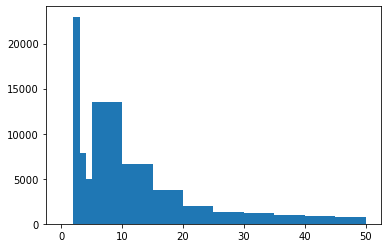

In [27]:
_ = plt.hist(dfo40cut['nDiaSources'], bins=[0,1,2,3,4,5,10,15,20,25,30,35,40, 45, 50])

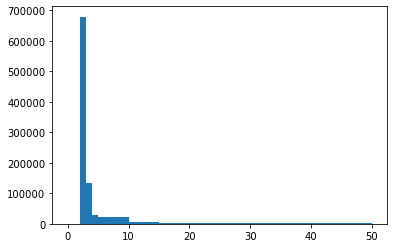

In [28]:
_ = plt.hist(dfocut['nDiaSources'], bins=[0,1,2,3,4,5,10,15,20,25,30,35,40, 45, 50])

As we can see above, there is also a large DiaObject discrepancy driven by a large difference (factor of 10)
in the number of single-source and two-source DiaObjects. The discrepancy gets smaller as you increase the minimum number of sources required for each DiaObject.

Overlay the diaObjects from each run to see if there are any systematic differences in location.

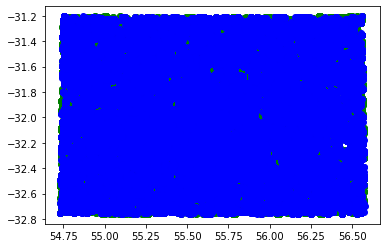

In [29]:
ax1 = plt.scatter(dfocut.ra,dfocut.decl,color='g')
ax2 = plt.scatter(dfo40cut.ra,dfo40cut.decl,color='b')
plt.show()

Compare source counts and log(SNR) only for sources with passing a SNR cut.

In [30]:
#Place a cut on SNR (defined here as psFlux/FluxErr
SNRcut = 10
binrange=range(32)
binsize=0.125
binrange= [ x*binsize for x in binrange]

Number of g-band sources rc2: 22027
Number of g-band sources w40: 22662
Number of r-band sources rc2: 49590
Number of r-band sources w40: 50920
Number of i-band sources rc2: 43136
Number of i-band sources w40: 47809
Number of z-band sources rc2: 22275
Number of z-band sources w40: 23435
Number of u-band sources rc2: 4141
Number of u-band sources w40: 4439
Number of y-band sources rc2: 8802
Number of y-band sources w40: 9127


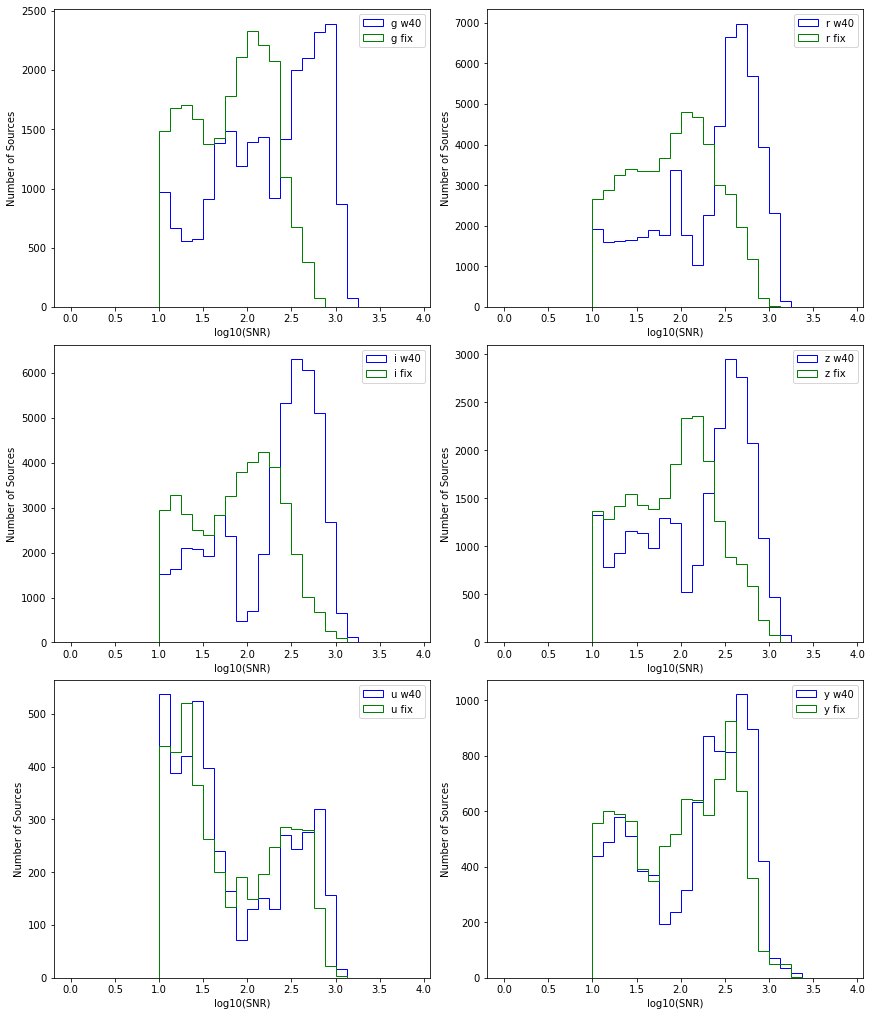

In [31]:
counter=0

myfig = plt.figure(constrained_layout=True, figsize=(12,14))
gs = myfig.add_gridspec(3, 2)

for myband in ['g', 'r', 'i', 'z', 'u', 'y']:
    mysrc = df.loc[(df['filterName'] == myband) & (df['pixelFlags_bad'] == False)\
                   & (df['shape_flag'] == False) & (df['centroid_flag']==False)\
                   & (np.abs(df['psFlux']/df['psFluxErr']) >= SNRcut),
                   ['ra','decl','psFlux','psFluxErr']]
    mysrc40 = df40.loc[(df40['filterName'] == myband) & (df40['pixelFlags_bad'] == False)
                     & (df40['shape_flag'] == False) & (df40['centroid_flag']==False)\
                     & (np.abs(df40['psFlux']/df40['psFluxErr']) >= SNRcut),
                       ['ra', 'decl','psFlux','psFluxErr']] 
    print('Number of %s-band sources rc2: %d' % (myband, len(mysrc)))
    print('Number of %s-band sources w40: %d' % (myband, len(mysrc40)))

# count vs log(SNR) as suggested by Zeljko
    myfig.add_subplot(gs[int(counter/2), counter%2])
    ax1 = plt.hist(np.log10(np.abs(mysrc40['psFlux']/mysrc40['psFluxErr'])),
                   color='b', bins=binrange,
                   histtype='step', label=myband+' w40')
    ax2 = plt.hist(np.log10(np.abs(mysrc['psFlux']/mysrc['psFluxErr'])),
                   color='g',bins=binrange,
                   histtype='step', label=myband+' fix')
    #plt.yscale('log')
    #plt.set_yscale('log')
    plt.xlabel('log10(SNR)')
    plt.ylabel('Number of Sources')
    plt.legend()
    mysrc = {}
    mysrc40 = {}
    counter += 1
myfig.show()
    

In [32]:
# Cleanup step
del dfo
del dfo40
del dfocut
del dfo40cut
gc.collect()

8639

## Crossmatch

In [33]:
MATCH_RADIUS_ARCSEC = 1.0

idx, d2d, d3d = diaSourcesc.match_to_catalog_sky(truthsc)

In [34]:
# Diagnostic
truth.iloc[idx]['id']

766815     31102001508
765926     30321354066
595865     31107731695
595555     30317262714
765930      4127592660
              ...     
4542429     4953056471
3453050     4939528936
4686981     4955877516
4552738     4953296979
3982533     4942599039
Name: id, Length: 2829000, dtype: object

In [35]:
idx, d2d, d3d = diaSourcesc.match_to_catalog_sky(truthsc)
# get back into pandas.  
df['truth_xmatch_dist_arcsec'] = d2d.to_value(u.arcsecond)
# Let's include all the matches, for reference
df['truth_xmatch_id_all'] = pd.Series(truth.iloc[idx]['id'].values, index=df.index)
# now make a column that only has the matches with radius.
df.loc[df['truth_xmatch_dist_arcsec'] <= MATCH_RADIUS_ARCSEC, 'truth_xmatch_id'] = df.loc[df['truth_xmatch_dist_arcsec'] <= MATCH_RADIUS_ARCSEC, 'truth_xmatch_id_all']

In [36]:
def confmat(wmatched, dfm):

    # true positives
    wtp = wmatched & (dfm['is_variable'] == 1) # have to use explicit equality since is_variable can be NaN when there is no truth counterpart
    ntp = np.sum(wtp)
    dfm.loc[wtp,'confusion_label'] = 'True Positive'
    print(ntp)
    # true negatives 
    wtn = ~wmatched & (dfm['is_variable'] == 0)
    ntn = np.sum(wtn)
    dfm.loc[wtn,'confusion_label'] = 'True Negative'
    print(ntn)
    # false positives (either a match to a non-variable source, or a DIASource with no truth table counterpart)
    wfp = (wmatched & (dfm['is_variable'] == 0)) | (dfm['id'].isnull())
    nfp = np.sum(wfp)
    dfm.loc[wfp,'confusion_label'] = 'False Positive'
    print(nfp)
    # false negatives (maybe!  depends how bright the variability is) 
    wfn = ~wmatched & (dfm['is_variable'] == 1)
    nfn = np.sum(wfn)
    dfm.loc[wfn,'confusion_label'] = 'False Negative'
    print(nfn)
    # now let's put this in sklearn language
    y_true = dfm['is_variable'] == 1.0
    y_pred = wmatched
    from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
    import seaborn as sns
    sns.set_context('talk')
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cm = confusion_matrix(y_true, y_pred, normalize='true')#, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)#,
                               #display_labels=clf.classes_)
    disp.plot(ax=ax)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cm = confusion_matrix(y_true, y_pred)#, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)#,
                               #display_labels=clf.classes_)
    disp.plot(ax=ax)
    completeness = cm[1,1]/np.sum(cm[1,:])
    purity = cm[1,1]/np.sum(cm[:,1])
    print(completeness, purity)
    return wtp, wtn, wfp, wfn

In [37]:
def fluxplots(dfm, wtp, wtn, wfp, wfn):
    
    fig = plt.figure(figsize=(12,8))
    bins = np.logspace(1,9,100)
    _ = plt.hist(dfm.loc[wtp,'flux_r'],bins=bins, label='TP', histtype='step')
    _ = plt.hist(dfm.loc[wfp,'flux_r'],bins=bins, label='FP', histtype='step')
    _ = plt.hist(dfm.loc[wtn,'flux_r'],bins=bins, label='TN', histtype='step')
    _ = plt.hist(dfm.loc[wfn,'flux_r'],bins=bins, label='FN', histtype='step')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('R-band flux (nJy)')
    plt.ylabel('Number of Sources')
    plt.show()
    fig = plt.figure(figsize=(12,8))
    bins = np.logspace(1,9,100)
    _ = plt.hist(dfm.loc[wtp,'flux_g'],bins=bins, label='TP', histtype='step')
    _ = plt.hist(dfm.loc[wfp,'flux_g'],bins=bins, label='FP', histtype='step')
    _ = plt.hist(dfm.loc[wtn,'flux_g'],bins=bins, label='TN', histtype='step')
    _ = plt.hist(dfm.loc[wfn,'flux_g'],bins=bins, label='FN', histtype='step')
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')

    plt.xlabel('G-band flux (nJy)')
    plt.ylabel('Number of Sources')
    plt.show()

In [38]:
# necessary to keep memory down
del df40
gc.collect()

0

In [39]:
dfm = pd.merge(truth,df,left_on='id',right_on='truth_xmatch_id',how='outer')
wmatched = (dfm['truth_xmatch_dist_arcsec'] <= MATCH_RADIUS_ARCSEC)

652669
4261021
2452623
19227
0.9713839641849333 0.4019566060859872


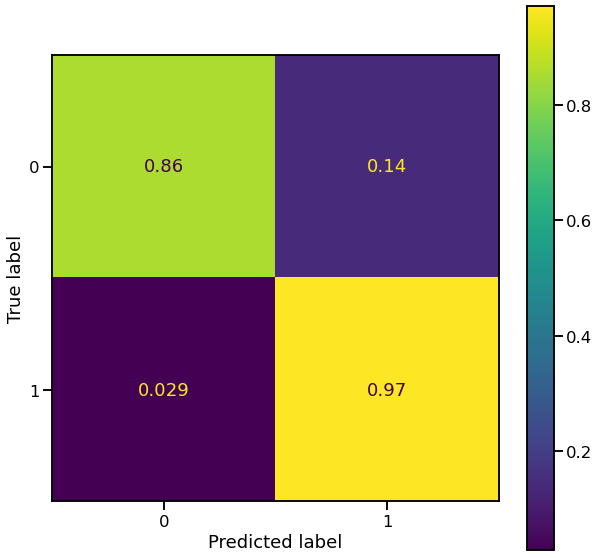

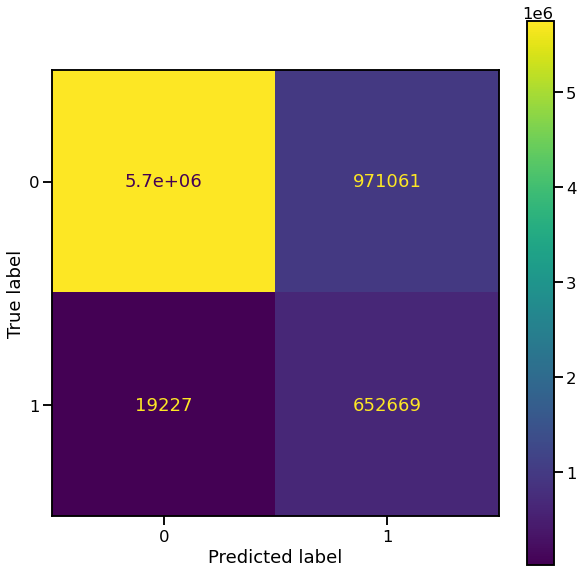

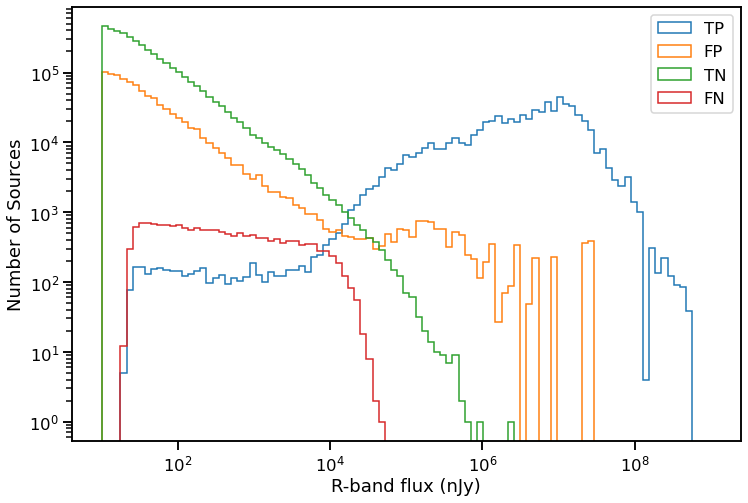

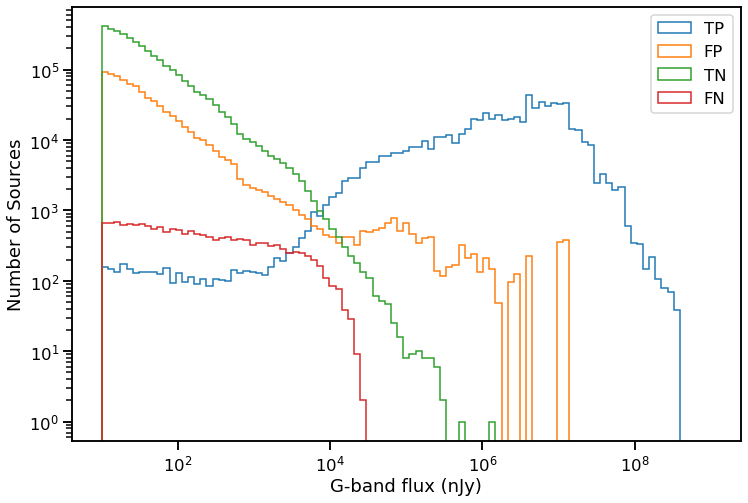

In [40]:
wtp, wtn, wfp, wfn = confmat(wmatched, dfm)
fluxplots(dfm, wtp, wtn, wfp, wfn)

### To do the same for the weekly 40 run we need to re-constitute the df40 table and delete the df table to keep memory consumption below 12 GB. For now we don't need to run that (see conclusions).

In [41]:
del df
del dfm
del wmatched
del wtp, wtn, wfp, wfn
del diaSourcesc
gc.collect()

35900

In [42]:
wherestr="instrument='LSSTCam-imSim' and tract=4431 and skymap='DC2'"


dataIds40 = set(butler40.registry.queryDataIds(['band', 'instrument', 'detector',
                                         'physical_filter', 'visit_system', 'visit'],
                                        datasets="goodSeeingDiff_diaSrcTable",
                                        collections=collection40,
                                        where=wherestr))
tables40 = []
for dataId in dataIds40:
    tables40.append(butler40.get('goodSeeingDiff_diaSrcTable', dataId=dataId))
df40 = pd.concat(tables40)
instrumentDataId = butler40.registry.expandDataId(instrument='LSSTCam-imSim')
packer = butler40.registry.dimensions.makePacker("visit_detector", instrumentDataId)
df40['visit'] = df40.ccdVisitId.apply(lambda x: packer.unpack(x)['visit'])
df40['detector'] = df40.ccdVisitId.apply(lambda x: packer.unpack(x)['detector'])
del dataIds40
del tables40
gc.collect()

0

In [43]:
idx, d2d, d3d = diaSourcesc40.match_to_catalog_sky(truthsc)
# get back into pandas.  
df40['truth_xmatch_dist_arcsec'] = d2d.to_value(u.arcsecond)
# Let's include all the matches, for reference
df40['truth_xmatch_id_all'] = pd.Series(truth.iloc[idx]['id'].values, index=df40.index)
# now make a column that only has the matches with radius.
df40.loc[df40['truth_xmatch_dist_arcsec'] <= MATCH_RADIUS_ARCSEC, 'truth_xmatch_id'] = df40.loc[df40['truth_xmatch_dist_arcsec'] <= MATCH_RADIUS_ARCSEC, 'truth_xmatch_id_all']

In [44]:
del diaSourcesc40, idx, d2d, d3d

In [45]:
# As mentioned above, the rest is commented out for now.

In [46]:
#dfm40 = pd.merge(truth,df40,left_on='id',right_on='truth_xmatch_id',how='outer')

#wmatched40 = (dfm40['truth_xmatch_dist_arcsec'] <= MATCH_RADIUS_ARCSEC)

#wtp40, wtn40, wfp40, wfn40 = confmat(dfm40, wmatched40)
#fluxplots(dfm40, wtp40, wtn40, wfp40, wfn40)

## Conclusions

The decorrelation afterburner tests show a significantly higher number of sources across the board, though less prounced in g-band and in high-SNR regions. The discrepancies are smaller as one applies tighter and tighter cuts on the source SNR.

It turns out that in the end the fix was backed out since that which the fix was supposed to correct actually wasn't a problem, so we document things here for completeness.